<a href="https://colab.research.google.com/github/amandaarr/perpustakaan/blob/master/KELOMPOK_19_OLAH_DATA_ARTIKEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1
# Import library utama untuk pengolahan data dan visualisasi

!pip install kmodes
import pandas as pd
import numpy as np

from kmodes.kmodes import KModes

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# CELL 2
# Membaca dataset transaksi pelanggan

file_path = '/content/dataset artikel 19.xlsx'
df = pd.read_excel(file_path)

df.head()


,Order ID,Order Substatus,Province,Payment Method,Product Category,SKU Subtotal After Discount
0,580590517128889788,Terkirim,Jawa Barat,PayLater,Sarung,709461
1,580589478990415363,Selesai,Jawa Tengah,Bayar di tempat,Sarung,253455
2,580589446447793884,Selesai,Kalimantan Selatan,Transfer bank,Sarung,1307792
3,580589394018272846,Selesai,Jawa Tengah,Bayar di tempat,Sarung,325531
4,580588984328685371,Selesai,Jawa Timur,Transfer bank,Sarung,374343


In [ ]:
# CELL 3
# Menghapus order_id dan memilih fitur relevan pola pembelian

df = df[
    [
        'Order ID',
        'Product Category',
        'Payment Method',
        'SKU Subtotal After Discount',
        'Order Substatus'
    ]
]


In [ ]:
# CELL 4
# Menghapus missing value agar K-Modes stabil

df = df.dropna()

df.isnull().sum()


,0
Order ID,0
Product Category,0
Payment Method,0
SKU Subtotal After Discount,0
Order Substatus,0


In [ ]:
# CELL 5
# Mengubah sku_subtotal menjadi kategori harga

df['price_range'] = pd.qcut(
    df['SKU Subtotal After Discount'],
    q=4,
    labels=[
        'Sangat Rendah',
        'Rendah',
        'Sedang',
        'Tinggi'
    ]
)

df.drop(columns=['SKU Subtotal After Discount'], inplace=True)


In [ ]:
# CELL 6
# Menggabungkan beberapa transaksi user menjadi satu pelanggan

# Perhatian: Kolom 'user_id' tidak ditemukan dalam DataFrame.
# Untuk sementara, kita akan menggunakan 'Order ID' sebagai pengelompokan.
# Harap diperhatikan bahwa ini akan memperlakukan setiap pesanan sebagai
# 'pelanggan' yang unik, yang mungkin tidak sesuai dengan tujuan
# 'menggabungkan beberapa transaksi user menjadi satu pelanggan'
# jika satu user bisa memiliki banyak Order ID.
# Jika Anda memiliki kolom ID pelanggan yang sebenarnya, harap gunakan itu.

df_customer = df.groupby('Order ID').agg({
    'Product Category': lambda x: x.mode()[0], # Mengubah 'sku_category'
    'Payment Method': lambda x: x.mode()[0],   # Mengubah 'payment_method'
    'price_range': lambda x: x.mode()[0],
    'Order Substatus': lambda x: x.mode()[0]   # Mengubah 'order_substatus'
}).reset_index()

df_customer.head()

,Order ID,Product Category,Payment Method,price_range,Order Substatus
0,580206442277209236,Sarung,Kartu kredit/debit,Tinggi,Dibatalkan
1,580206464637568148,Sarung,Kartu kredit/debit,Tinggi,Selesai
2,580211456736659114,Sarung,Bayar di tempat,Sangat Rendah,Selesai
3,580213544508753838,Sarung,Bayar di tempat,Rendah,Selesai
4,580214253675054505,Sarung,Transfer bank,Sangat Rendah,Dibatalkan


In [ ]:
# CELL 7
# order_substatus dijadikan hasil keputusan (bukan fitur clustering)

decision_label = df_customer['Order Substatus']

X = df_customer.drop(
    columns=['Order ID', 'Order Substatus']
)


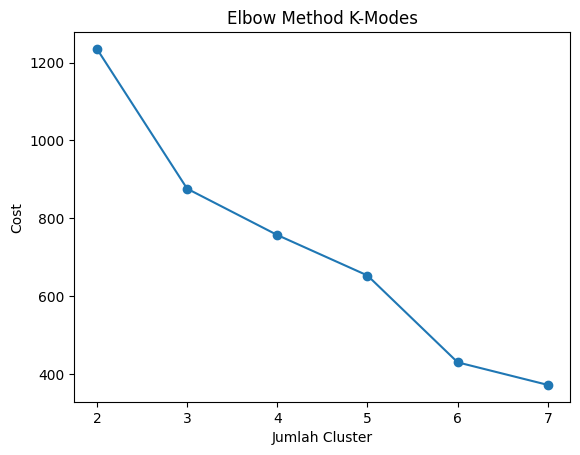

In [ ]:
# CELL 8
# Menentukan jumlah cluster optimal dengan cost K-Modes

cost = []
K_range = range(2, 8)

for k in K_range:
    km = KModes(
        n_clusters=k,
        init='Huang',
        n_init=5,
        verbose=0
    )
    km.fit_predict(X)
    cost.append(km.cost_)

plt.plot(K_range, cost, marker='o')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Cost')
plt.title('Elbow Method K-Modes')
plt.show()


In [ ]:
# CELL 9
# Klasterisasi final menggunakan jumlah cluster optimal

k_optimal = 6  # sesuaikan hasil elbow

km_final = KModes(
    n_clusters=k_optimal,
    init='Huang',
    n_init=10,
    verbose=1
)

clusters = km_final.fit_predict(X)

df_customer['cluster'] = clusters


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 125, cost: 449.0
Run 1, iteration: 2/100, moves: 0, cost: 449.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 279, cost: 408.0
Run 2, iteration: 2/100, moves: 46, cost: 408.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 621.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 67, cost: 566.0
Run 4, iteration: 2/100, moves: 0, cost: 566.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 127, cost: 574.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 136, cost: 566.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, 

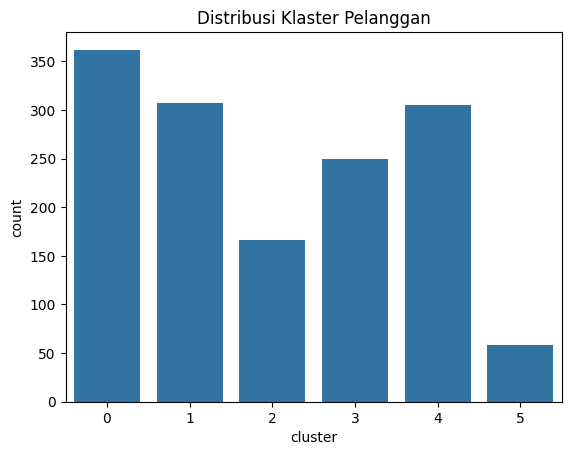

In [ ]:
# CELL 10
# Visualisasi jumlah pelanggan per cluster

sns.countplot(x='cluster', data=df_customer)
plt.title('Distribusi Klaster Pelanggan')
plt.show()


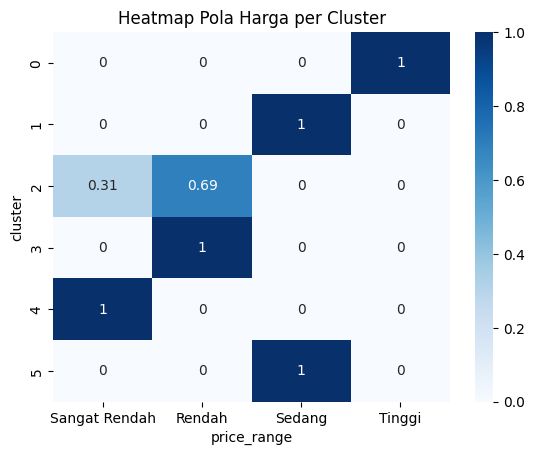

In [ ]:
# CELL 11
# Heatmap frekuensi kategori per cluster

cluster_profile = pd.crosstab(
    df_customer['cluster'],
    df_customer['price_range'],
    normalize='index'
)

sns.heatmap(
    cluster_profile,
    annot=True,
    cmap='Blues'
)
plt.title('Heatmap Pola Harga per Cluster')
plt.show()


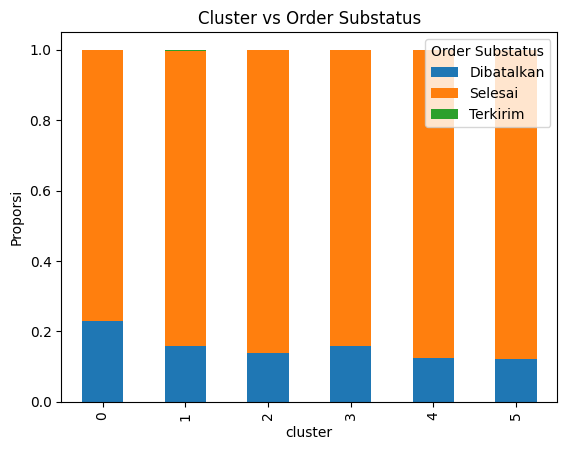

In [ ]:
# CELL 12
# Hubungan cluster dengan order_substatus

decision_cluster = pd.crosstab(
    df_customer['cluster'],
    decision_label,
    normalize='index'
)

decision_cluster.plot(
    kind='bar',
    stacked=True
)

plt.title('Cluster vs Order Substatus')
plt.ylabel('Proporsi')
plt.show()


In [ ]:
# CELL 13
# Menyimpan hasil klasterisasi

df_customer.to_excel(
    'hasil_klaster_pelanggan_kmodes_per_sheet.xlsx',
    index=False
)

print("File berhasil disimpan")


File berhasil disimpan
